In [6]:
import os
import glob
import math
import librosa
import librosa.display
import matplotlib.pyplot as plt

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [7]:
DATA_PATH = '[WRITE_YOUR_DATA_PATH]'

In [8]:
wav_files = glob.glob(os.path.join(DATA_PATH, '*.wav'))

In [9]:
class Biquad:

  # pretend enumeration
  LOWPASS, HIGHPASS, BANDPASS, PEAK, NOTCH, LOWSHELF, HIGHSHELF = range(7)

  def __init__(self, typ, freq, srate, Q, dbGain=0):
    types = {
      Biquad.LOWPASS : Biquad.lowpass,
      Biquad.HIGHPASS : Biquad.highpass,
      Biquad.BANDPASS : Biquad.bandpass,
      Biquad.PEAK : Biquad.peak,
      Biquad.NOTCH : Biquad.notch,
      Biquad.LOWSHELF : Biquad.lowshelf,
      Biquad.HIGHSHELF : Biquad.highshelf
    }
    assert typ in types
    self.typ = typ
    self.freq = float(freq)
    self.srate = float(srate)
    self.Q = float(Q)
    self.dbGain = float(dbGain)
    self.a0 = self.a1 = self.a2 = 0
    self.b0 = self.b1 = self.b2 = 0
    self.x1 = self.x2 = 0
    self.y1 = self.y2 = 0
    # only used for peaking and shelving filter types
    A = math.pow(10, dbGain / 40)
    omega = 2 * math.pi * self.freq / self.srate
    sn = math.sin(omega)
    cs = math.cos(omega)
    alpha = sn / (2*Q)
    beta = math.sqrt(A + A)
    types[typ](self,A, omega, sn, cs, alpha, beta)
    # prescale constants
    self.b0 /= self.a0
    self.b1 /= self.a0
    self.b2 /= self.a0
    self.a1 /= self.a0
    self.a2 /= self.a0

  def lowpass(self,A, omega, sn, cs, alpha, beta):
    self.b0 = (1 - cs) /2
    self.b1 = 1 - cs
    self.b2 = (1 - cs) /2
    self.a0 = 1 + alpha
    self.a1 = -2 * cs
    self.a2 = 1 - alpha

  def highpass(self, A, omega, sn, cs, alpha, beta):
    self.b0 = (1 + cs) /2
    self.b1 = -(1 + cs)
    self.b2 = (1 + cs) /2
    self.a0 = 1 + alpha
    self.a1 = -2 * cs
    self.a2 = 1 - alpha

  def bandpass(self, A, omega, sn, cs, alpha, beta):
    self.b0 = alpha
    self.b1 = 0
    self.b2 = -alpha
    self.a0 = 1 + alpha
    self.a1 = -2 * cs
    self.a2 = 1 - alpha

  def notch(self, A, omega, sn, cs, alpha, beta):
    self.b0 = 1
    self.b1 = -2 * cs
    self.b2 = 1
    self.a0 = 1 + alpha
    self.a1 = -2 * cs
    self.a2 = 1 - alpha

  def peak(self, A, omega, sn, cs, alpha, beta):
    self.b0 = 1 + (alpha * A)
    self.b1 = -2 * cs
    self.b2 = 1 - (alpha * A)
    self.a0 = 1 + (alpha /A)
    self.a1 = -2 * cs
    self.a2 = 1 - (alpha /A)

  def lowshelf(self, A, omega, sn, cs, alpha, beta):
    self.b0 = A * ((A + 1) - (A - 1) * cs + beta * sn)
    self.b1 = 2 * A * ((A - 1) - (A + 1) * cs)
    self.b2 = A * ((A + 1) - (A - 1) * cs - beta * sn)
    self.a0 = (A + 1) + (A - 1) * cs + beta * sn
    self.a1 = -2 * ((A - 1) + (A + 1) * cs)
    self.a2 = (A + 1) + (A - 1) * cs - beta * sn

  def highshelf(self, A, omega, sn, cs, alpha, beta):
    self.b0 = A * ((A + 1) + (A - 1) * cs + beta * sn)
    self.b1 = -2 * A * ((A - 1) + (A + 1) * cs)
    self.b2 = A * ((A + 1) + (A - 1) * cs - beta * sn)
    self.a0 = (A + 1) - (A - 1) * cs + beta * sn
    self.a1 = 2 * ((A - 1) - (A + 1) * cs)
    self.a2 = (A + 1) - (A - 1) * cs - beta * sn

  # perform filtering function
  def __call__(self, x):
    y = self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 - self.a1 * self.y1 - self.a2 * self.y2
    self.x2 = self.x1
    self.x1 = x
    self.y2 = self.y1
    self.y1 = y
    return y
    
  # provide a static result for a given frequency f
  def result(self, f):
    phi = (math.sin(math.pi * f * 2/(2*self.srate)))**2
    r =((self.b0+self.b1+self.b2)**2 - \
    4*(self.b0*self.b1 + 4*self.b0*self.b2 + \
    self.b1*self.b2)*phi + 16*self.b0*self.b2*phi*phi) / \
    ((1+self.a1+self.a2)**2 - 4*(self.a1 + 4*self.a2 + \
    self.a1*self.a2)*phi + 16*self.a2*phi*phi)
    if(r < 0):
      r = 0
    return r**(.5)

  # provide a static log result for a given frequency f
  def log_result(self, f):
    try:
      r = 20 * math.log10(self.result(f))
    except:
      r = -200
    return r

  # return computed constants
  def constants(self):
    return self.a1, self.a2, self.b0, self.b1, self.b2
    
  def __str__(self):
    return "Type:%d,Freq:%.1f,Rate:%.1f,Q:%.1f,Gain:%.1f" % (self.typ,self.freq,self.srate,self.Q,self.dbGain)

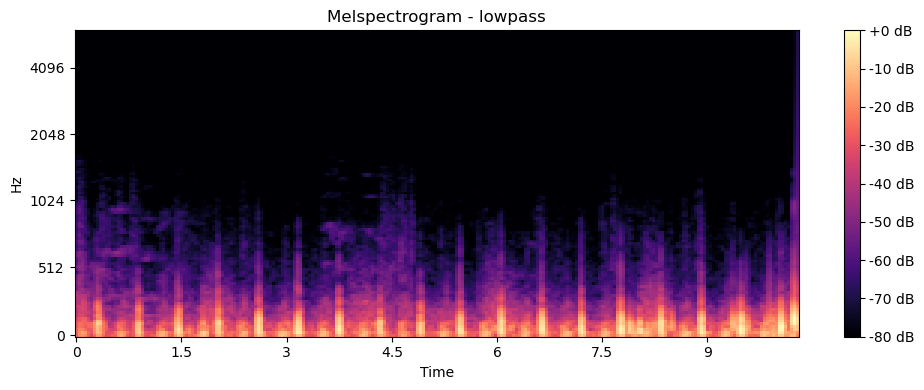

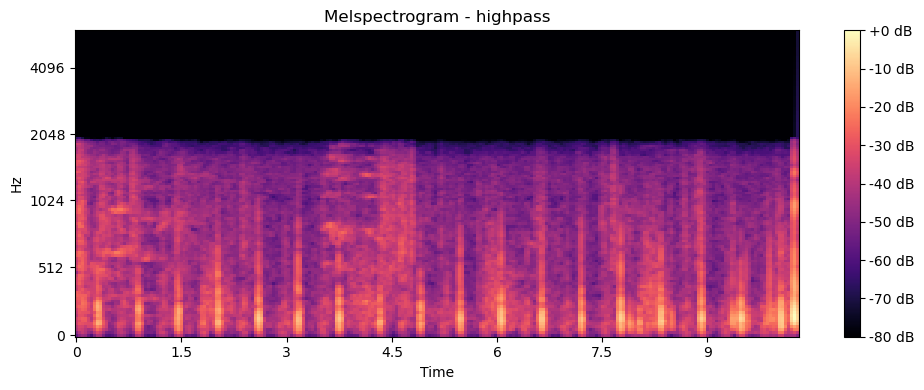

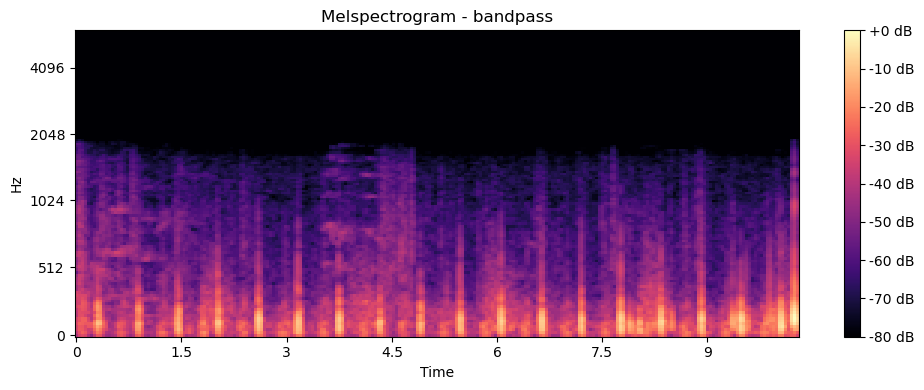

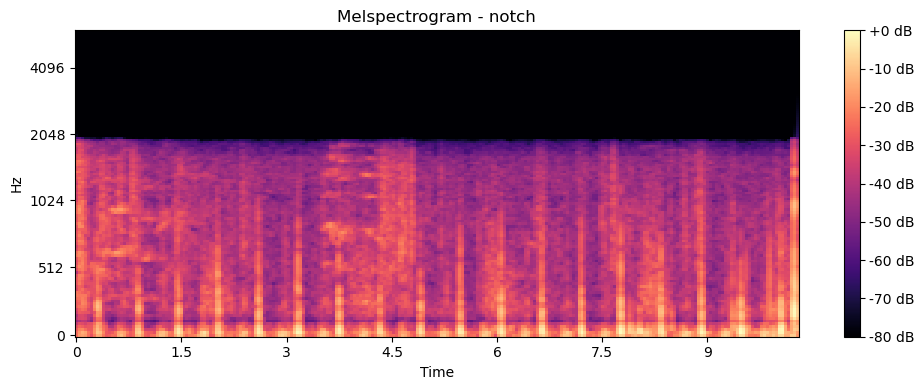

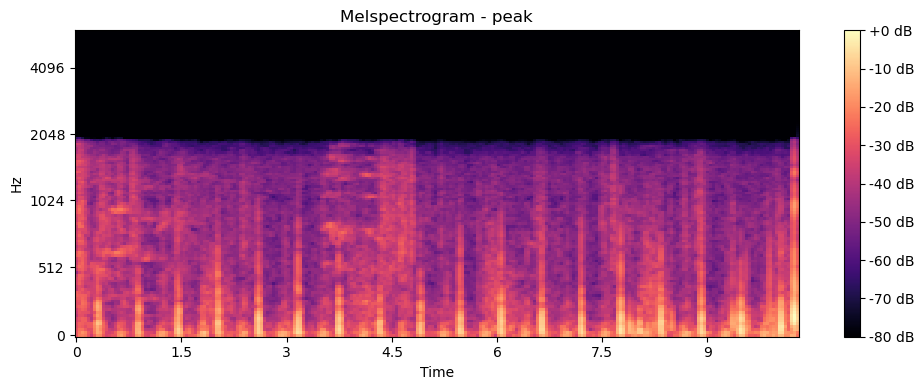

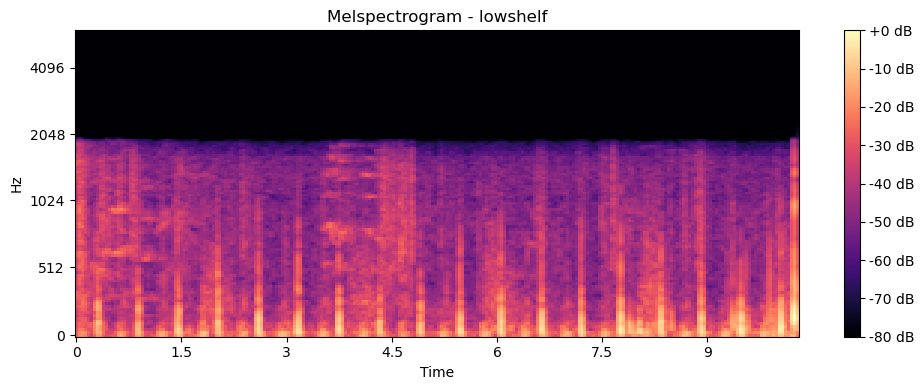

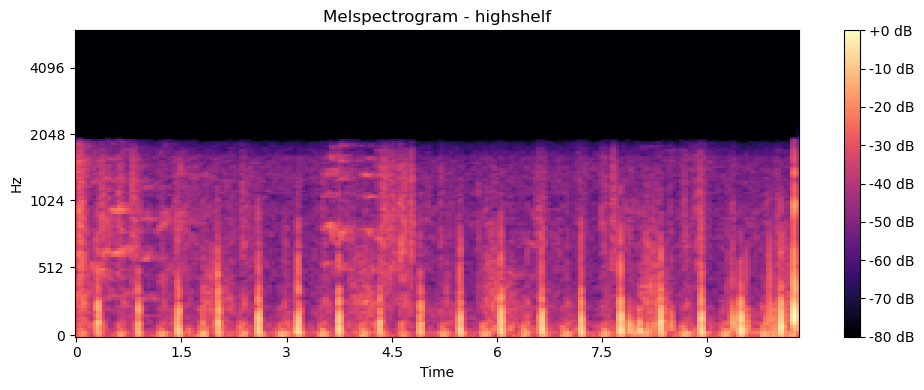

In [10]:
import soundfile as sf
import numpy as np

# 필터링 비교를 위한 샘플 데이터
sample_wav = wav_files[0]
y, sr = librosa.load(sample_wav, sr=12000)

# 필터링을 적용하여 음성 데이터를 저장
def apply_filter(y, sr, filter_type, filter_params, filter_name):
    if filter_type == 'biquad':
        biquad = Biquad(*filter_params)
        y_filtered = np.array([biquad(sample) for sample in y])
    else:
        raise ValueError("Unknown filter type")
    sf.write(f'{filter_name}_filtered.wav', y_filtered, sr)
    return y_filtered

# 필터의 종류, 125Hz를 중간 주파수로 지정(심음 : 0~250Hz)
filters = [
    ('lowpass', 'biquad', (Biquad.LOWPASS, 125, sr, 1.0)),
    ('highpass', 'biquad', (Biquad.HIGHPASS, 125, sr, 1.0)),
    ('bandpass', 'biquad', (Biquad.BANDPASS, 125, sr, 1.0)),
    ('notch', 'biquad', (Biquad.NOTCH, 125, sr, 1.0)),
    ('peak', 'biquad', (Biquad.PEAK, 125, sr, 1.0, 1.0)),
    ('lowshelf', 'biquad', (Biquad.LOWSHELF, 125, sr, 1.0, 1.0)),
    ('highshelf', 'biquad', (Biquad.HIGHSHELF, 125, sr, 1.0, 1.0))
]

for filter_name, filter_type, filter_params in filters:
    y_filtered = apply_filter(y, sr, filter_type, filter_params, filter_name)
    
    # 멜스펙트로그램 계산
    S_filtered = librosa.feature.melspectrogram(y=y_filtered, sr=sr)
    log_S_filtered = librosa.power_to_db(S_filtered, ref=np.max)
    
    # 결과 시각화
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_S_filtered, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+02.0f dB')
    plt.title(f'Melspectrogram - {filter_name}')
    plt.tight_layout()
    plt.show()